In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1752126362547940540
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18361771821091927619
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
!pip install boto3


In [ ]:
#import boto3
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img


In [ ]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
# Print shapes of the arrays
print("x_train shape:", x_train.shape)
print("x_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
x_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:


# Select a subset of 500 samples from each class
num_samples_per_class = 500
x_train_subset = []
y_train_subset = []
for class_label in range(100):
    class_indices = (y_train == class_label).flatten()
    x_train_class = x_train[class_indices][:num_samples_per_class]
    y_train_class = y_train[class_indices][:num_samples_per_class]
    x_train_subset.append(x_train_class)
    y_train_subset.append(y_train_class)



In [ ]:

x_train_subset = np.concatenate(x_train_subset, axis=0)
y_train_subset = np.concatenate(y_train_subset, axis=0)

# Preprocess and normalize images
x_train_preprocessed = tf.keras.applications.vgg16.preprocess_input(x_train_subset)
x_test_preprocessed = tf.keras.applications.vgg16.preprocess_input(x_test)

# One-hot encode labels
num_classes_fine = len(set(y_train_subset.flatten()))
y_train_fine_encoded = to_categorical(y_train_subset, num_classes_fine)
y_test_fine_encoded = to_categorical(y_test, num_classes_fine)

print("x_train_preprocessed shape:", x_train_preprocessed.shape)
print("x_test_preprocessed shape:", x_test_preprocessed.shape)
print("y_train_fine_encoded shape:", y_train_fine_encoded.shape)
print("y_test_fine_encoded shape:", y_test_fine_encoded.shape)

x_train_preprocessed shape: (50000, 32, 32, 3)
x_test_preprocessed shape: (10000, 32, 32, 3)
y_train_fine_encoded shape: (50000, 100)
y_test_fine_encoded shape: (10000, 100)


In [ ]:


from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Resize images to (224, 224)
x_train_preprocessed_resized = []
for img in x_train_preprocessed:
    resized_img = img_to_array(array_to_img(img).resize((64, 64)))
    x_train_preprocessed_resized.append(resized_img)

x_train_preprocessed_resized = np.array(x_train_preprocessed_resized)
print("x_train_preprocessed_resized shape:", x_train_preprocessed_resized.shape)

x_train_preprocessed_resized shape: (50000, 64, 64, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Resize images to (224, 224)
x_test_preprocessed_resized = []
for img in x_test_preprocessed:
    resized_img = img_to_array(array_to_img(img).resize((64, 64)))
    x_test_preprocessed_resized.append(resized_img)

x_test_preprocessed_resized = np.array(x_test_preprocessed_resized)
print("x_test_preprocessed_resized shape:", x_test_preprocessed_resized.shape)


x_test_preprocessed_resized shape: (10000, 64, 64, 3)


In [ ]:
import numpy as np
from google.colab import files

# Save preprocessed data
np.save('x_train_preprocessed.npy', x_train_preprocessed)
np.save('y_train_fine_encoded.npy', y_train_fine_encoded)
np.save('x_test_preprocessed.npy', x_test_preprocessed)
np.save('y_test_fine_encoded.npy', y_test_fine_encoded)


In [ ]:
# Download files to local machine
files.download('x_train_preprocessed.npy')
files.download('y_train_fine_encoded.npy')
files.download('x_test_preprocessed.npy')
files.download('y_test_fine_encoded.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from google.colab import files

# Load the files
x_train_preprocessed = np.load('x_train_preprocessed.npy')
y_train_fine_encoded = np.load('y_train_fine_encoded.npy')
x_test_preprocessed = np.load('x_test_preprocessed.npy')
y_test_fine_encoded = np.load('y_test_fine_encoded.npy')


In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess your data
# Assuming x_train_preprocessed_resized, y_train_fine_encoded, x_test_preprocessed, y_test_fine_encoded are properly loaded and preprocessed

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(100, activation='softmax')(x)  # Change 10 to the correct number of classes

# Create the modified model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_preprocessed_resized, y_train_fine_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(x_test_preprocessed_resized, y_test_fine_encoded)
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_preprocessed_resized, y_test_fine_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Epoch 1/10
1563/1563 [==============================] - 30s 18ms/step - loss: 3.4798 - accuracy: 0.2626 - val_loss: 2.6893 - val_accuracy: 0.3278
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 2.3873 - accuracy: 0.3890 - val_loss: 2.5511 - val_accuracy: 0.3659
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 2.1059 - accuracy: 0.4415 - val_loss: 2.5494 - val_accuracy: 0.3861
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.9262 - accuracy: 0.4786 - val_loss: 2.5641 - val_accuracy: 0.3946
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7848 - accuracy: 0.5128 - val_loss: 2.6611 - val_accuracy: 0.3992
Epoch 6/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6711 - accuracy: 0.5393 - val_loss: 2.8269 - val_accuracy: 0.4004
Epoch 7/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5917 - accuracy: 0.5595 - val_loss: 2.8808 -

In [ ]:
import logging
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a file handler and set the log level to INFO
file_handler = logging.FileHandler('/content/imagecaptioning.log')
file_handler.setLevel(logging.INFO)

# Create a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

logger.info(model.summary())
logger.info(history)

# Store Accuracy
logger.info('Test Accuracy:')
logger.info(accuracy * 100)
logger.info('Test Loss:')
logger.info(loss)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

INFO:__main__:None
INFO:__main__:<keras.callbacks.History object at 0x7d497a968af0>
INFO:__main__:Test Accuracy:
INFO:__main__:40.65999984741211
INFO:__main__:Test Loss:
INFO:__main__:3.212869882583618


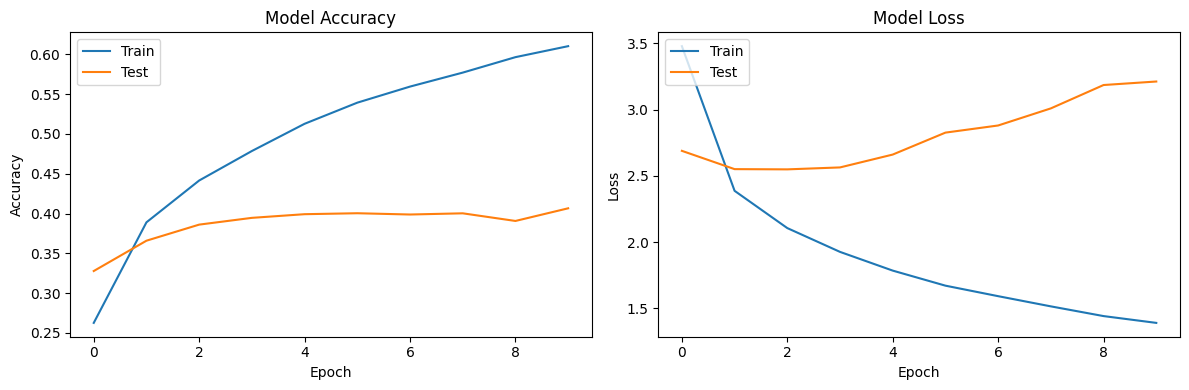

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
# Load the pre-trained ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(100, activation='softmax')(x)  # Change 10 to the correct number of classes

# Create the modified model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train_preprocessed_resized, y_train_fine_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(x_test_preprocessed_resized, y_test_fine_encoded)
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_preprocessed_resized, y_test_fine_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# After training
model.save('trained_resnet50_model.h5')


Epoch 1/10
1563/1563 [==============================] - 32s 18ms/step - loss: 2.6013 - accuracy: 0.3556 - val_loss: 2.1962 - val_accuracy: 0.4221
Epoch 2/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.8728 - accuracy: 0.4899 - val_loss: 2.1165 - val_accuracy: 0.4470
Epoch 3/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.5762 - accuracy: 0.5536 - val_loss: 2.1336 - val_accuracy: 0.4565
Epoch 4/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3477 - accuracy: 0.6082 - val_loss: 2.2678 - val_accuracy: 0.4637
Epoch 5/10
1563/1563 [==============================] - 27s 18ms/step - loss: 1.1628 - accuracy: 0.6565 - val_loss: 2.3677 - val_accuracy: 0.4689
Epoch 6/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0129 - accuracy: 0.6954 - val_loss: 2.5263 - val_accuracy: 0.4716
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8836 - accuracy: 0.7313 - val_loss: 2.6747 -

In [ ]:
import logging
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a file handler and set the log level to INFO
file_handler = logging.FileHandler('/content/imagecaptioningresnet50.log')
file_handler.setLevel(logging.INFO)

# Create a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

logger.info(model.summary())
logger.info(history)

# Store Accuracy
logger.info('Test Accuracy:')
logger.info(accuracy * 100)
logger.info('Test Loss:')
logger.info(loss)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

INFO:__main__:None
INFO:__main__:<keras.callbacks.History object at 0x7d4b4df6f850>
INFO:__main__:Test Accuracy:
INFO:__main__:46.869999170303345
INFO:__main__:Test Loss:
INFO:__main__:3.3572182655334473


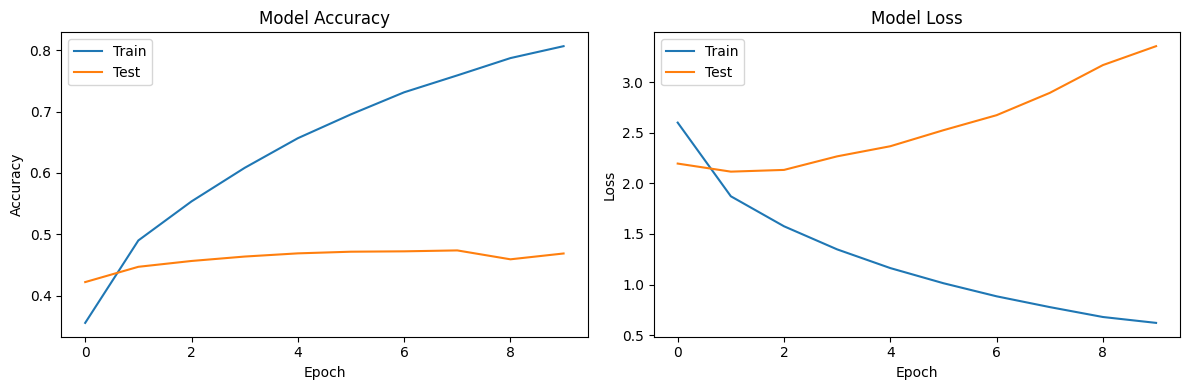

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
pip install transformers


A simple image captioning technique with gpt2 model

In [ ]:
import torch
from PIL import Image
from torchvision.models import resnet50
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load ResNet-50 model
resnet = resnet50(pretrained=True)
resnet.eval()

# Load GPT-2 model and tokenizer
model_name = "gpt2"  # Choose the appropriate model variant
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Load and preprocess the image
image_path = "/content/images.jpeg"  # Replace with the actual path
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image_tensor = preprocess(image).unsqueeze(0)

# Extract image features
with torch.no_grad():
    image_features = resnet(image_tensor)

# Generate captions using GPT-2 model
input_text = "A photo of a "  # Starting prompt
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate caption using GPT-2 model
with torch.no_grad():
    output = model.generate(
        input_ids,
        attention_mask=None,
        do_sample=True,
        max_length=50,  # Adjust as needed
        temperature=0.7,  # Adjust as needed
    )

generated_caption = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Caption:", generated_caption)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Caption: A photo of a  Drake video  has been circulating on social networks.
If you don't have a clue what a Drake video is, try this video from July 12th, 2012. The video begins with a Drake song called


In [ ]:
pip install accelerate==0.20.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
pip install transformers[torch] -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


A fine tunned image captioning technique with gpt2 model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.cuda.amp import autocast, GradScaler

# Load GPT-2 model and tokenizer
model_name = "gpt2"  # Choose the appropriate model variant
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the padding token for the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, captions_file, tokenizer):
        self.image_folder = image_folder
        self.captions_file = captions_file
        self.tokenizer = tokenizer

        # Load and preprocess captions
        self.image_to_captions = self.load_data()

    def __len__(self):
        return len(self.image_to_captions)

    def __getitem__(self, idx):
        image_filename = list(self.image_to_captions.keys())[idx]
        image_path = os.path.join(self.image_folder, image_filename)
        captions = self.image_to_captions[image_filename]

        try:
            image = Image.open(image_path).convert("RGB")
            image = image_transform(image)
        except FileNotFoundError:
            # If the image file doesn't exist, skip it and move to the next image
            return self.__getitem__((idx + 1) % len(self))

        return image, captions

    def load_data(self):
        image_to_captions = {}

        with open(self.captions_file, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split("\t")
            image_filename = parts[0].split('#')[0]  # Get the base filename
            caption = parts[1]

            if image_filename not in image_to_captions:
                image_to_captions[image_filename] = []
            image_to_captions[image_filename].append(caption)

        return image_to_captions

# Define paths to the dataset folders and captions file
image_folder = "/content/drive/MyDrive/Flicker8k_Dataset"
captions_file = "/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt"

# Create the dataset
dataset = Flickr8kDataset(image_folder, captions_file, tokenizer)

# Create the dataset using only a subset of 2000 data points
subset_size = 5000
subset_indices = list(range(subset_size))
dataset.image_to_captions = {k: v for i, (k, v) in enumerate(dataset.image_to_captions.items()) if i in subset_indices}

# Create a DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define your training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scaler = GradScaler()

# Loop through your dataset and train the model
accumulation_steps = 8  # Accumulate gradients over 8 batches
for epoch in range(5):
    for batch_idx, batch in enumerate(dataloader):
        images, captions = batch
        images = images.to(device)

        with autocast():
            # Tokenize captions and pad them to the same length
            max_caption_length = max(len(tokenizer.encode(caption)) for caption in captions)
            tokenized_captions = [tokenizer.encode(caption, padding="max_length", max_length=max_caption_length) for caption in captions]
            tokenized_captions = torch.tensor(tokenized_captions).to(device, dtype=torch.long)  # Ensure long type

            # Generate input and labels for the model
            input_ids = tokenized_captions[:, :-1]
            labels = tokenized_captions[:, 1:]

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Clear GPU memory
        del tokenized_captions, input_ids, labels
        torch.cuda.empty_cache()

# Save the fine-tuned model
model.save_pretrained("./captioning_finetuned")


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned GPT-2 model
model_path = "/content/captioning_finetuned"
model = GPT2LMHeadModel.from_pretrained(model_path)

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the device for model inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load an image from CIFAR-100 (you need to replace this with actual image loading code)
image = Image.open("/content/drive/MyDrive/Flicker8k_Dataset/2090386465_b6ebb7df2c.jpg")
image = image_transform(image)  # Apply the same transform as used during training

# Generate caption for the image
def generate_caption(model, tokenizer, image, max_length=50):
    model.eval()
    with torch.no_grad():
        input_ids = tokenizer.encode("A photo of a", return_tensors="pt").to(device)  # Starting prompt

        for step in range(max_length):
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]  # Logits for the last token
            predicted_token_id = torch.argmax(logits, dim=-1)
            input_ids = torch.cat((input_ids, predicted_token_id.unsqueeze(-1)), dim=-1)

            if predicted_token_id == tokenizer.eos_token_id:
                break

        generated_caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return generated_caption

# Generate caption for the image
generated_caption = generate_caption(model, tokenizer, image)
print("Generated Caption:", generated_caption)


Generated Caption: A photo of a man who was shot and killed by police in the city of San Francisco, California, on July 9, 2015. (Photo by Michael Macor, AP)

Read or Share this story: http://usat.ly/1jY3


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model and tokenizer
model_name = "gpt2"  # Choose the appropriate model variant
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset class
class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, captions_folder, tokenizer):
        self.image_folder = image_folder
        self.captions_folder = captions_folder
        self.tokenizer = tokenizer

        # Load and preprocess captions
        self.image_paths, self.captions = self.load_data()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_paths[idx])
        caption = self.captions[idx]

        image = Image.open(image_path).convert("RGB")
        image = image_transform(image)

        return image, caption

    def load_data(self):
        image_paths = []
        captions = []

        # Load image paths
        for filename in os.listdir(self.image_folder):
            if filename.endswith(".jpg"):
                image_paths.append(filename)

        # Load captions
        for filename in os.listdir(self.captions_folder):
            if filename.endswith(".txt"):
                with open(os.path.join(self.captions_folder, filename), "r") as f:
                    caption_lines = f.read().strip().split("\n")
                    captions.extend(caption_lines)

        return image_paths, captions

# Define paths to the dataset folders
image_folder = "/content/drive/MyDrive/Flicker8k_Dataset"
captions_folder = "/content/drive/MyDrive/Flickr8k_text"

# Create the dataset
dataset = Flickr8kDataset(image_folder, captions_folder, tokenizer)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define your training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Inside the training loop
for epoch in range(10):
    for images, captions in dataloader:
        images = images.to(device)

        # Tokenize captions and pad them to the same length
        max_caption_length = max(len(tokenizer.encode(caption)) for caption in captions)
        tokenized_captions = [tokenizer.encode(caption, padding="max_length", max_length=max_caption_length) for caption in captions]
        tokenized_captions = torch.tensor(tokenized_captions).to(device)

        optimizer.zero_grad()
        outputs = model(images, labels=tokenized_captions)
        loss = outputs.loss
        loss.backward()
        optimizer.step()



# Save the fine-tuned model
model.save_pretrained("./captioning_finetuned")


In [ ]:
# Load two GPT-2 models with different seeds
model1 = GPT2LMHeadModel.from_pretrained("gpt2")
model2 = GPT2LMHeadModel.from_pretrained("gpt2")

# Generate captions using both models
caption1 = generate_caption(model1, image_features)  # Implement your caption generation function
caption2 = generate_caption(model2, image_features)

# Combine captions using voting or other techniques
combined_caption = ensemble_captions([caption1, caption2])  # Implement your ensemble function
print("Ensemble Caption:", combined_caption)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Flickr8k Dataset captions from a text file
captions_path = 'captions.txt'  # Replace with your captions file path
with open(captions_path, 'r') as f:
    captions_data = f.readlines()

# Extract captions and image filenames from captions_data
captions = [line.strip().split(',')[1] for line in captions_data]
image_filenames = [line.strip().split(',')[0] for line in captions_data]

# Preprocess the captions and build a vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token='<unk>')
tokenizer.fit_on_texts(captions)

# Pad sequences and create caption sequences
max_caption_length = 20
captions_sequences = tokenizer.texts_to_sequences(captions)
padded_captions = pad_sequences(captions_sequences, maxlen=max_caption_length, padding='post')

# Load and preprocess images using a pre-trained model (InceptionV3)
image_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = Model(new_input, hidden_layer)

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array

# Load image filenames
image_filenames = [caption.split('\t')[0] for caption in captions_data]

# Create arrays to store image features and caption sequences
image_features = []
for filename in image_filenames:
    img_path = 'images/' + filename  # Replace with your image path
    img = preprocess_image(img_path)
    img_features = image_features_extract_model.predict(img)
    image_features.append(img_features)

image_features = np.array(image_features)
padded_captions = np.array(padded_captions)


# Define the image captioning model architecture
image_input = Input(shape=image_features.shape[1:])
image_features_input = Dense(256, activation='relu')(image_input)
sequence_input = Input(shape=(max_caption_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256)(sequence_input)
lstm_layer = LSTM(256)(embedding_layer)
decoder_input = tf.keras.layers.concatenate([image_features_input, lstm_layer], axis=-1)
output_layer = Dense(len(tokenizer.word_index) + 1, activation='softmax')(decoder_input)

image_captioning_model = Model(inputs=[image_input, sequence_input], outputs=output_layer)
image_captioning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the image captioning model
image_captioning_model.fit([image_features, padded_captions], padded_captions, epochs=10, batch_size=64)

# Save the trained model
image_captioning_model.save('image_captioning_model.h5')

# Generate captions using the trained model
def generate_caption(image_feature, model, tokenizer, max_caption_length=20):
    start_word = tokenizer.word_index['<start>']
    end_word = tokenizer.word_index['<end>']
    caption = [start_word]

    for _ in range(max_caption_length):
        sequence = pad_sequences([caption], maxlen=max_caption_length, padding='post')
        predicted_word_index = model.predict([image_feature, sequence])
        predicted_word_index = np.argmax(predicted_word_index)

        if predicted_word_index == end_word:
            break

        caption.append(predicted_word_index)

    caption_words = tokenizer.sequences_to_texts([caption])[0]
    return caption_words

# Load the trained model
trained_model = tf.keras.models.load_model('image_captioning_model.h5')

# Example image for generating captions
test_image_path = '/content/photography-01-800x400.jpg'  # Replace with your test image path
test_image = preprocess_image(test_image_path)
test_image_feature = image_features_extract_model.predict(test_image)

# Generate caption for the test image
generated_caption = generate_caption(test_image_feature, trained_model, tokenizer, max_caption_length)
print("Generated Caption:", generated_caption)


In [ ]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense


# Create a simple CNN model
input_shape = (64, 64, 3)  # Specify the correct input shape
model_input = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
print("After Conv2D(32):", x.shape)

x = MaxPooling2D((2, 2), padding='same')(x)
print("After MaxPooling2D(2, 2):", x.shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
print("After Conv2D(64):", x.shape)

x = MaxPooling2D((2, 2), padding='same')(x)
print("After MaxPooling2D(2, 2):", x.shape)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
print("After Conv2D(128):", x.shape)

x = MaxPooling2D((2, 2), padding='same')(x)
print("After MaxPooling2D(2, 2):", x.shape)

x = Flatten()(x)
print("After Flatten:", x.shape)
x = Dense(256, activation='relu')(x)
print("After Dense:", x.shape)
output = Dense(10, activation='softmax')(x)  # Assuming you have 10 classes
print("After output:", x.shape)
model = Model(inputs=model_input, outputs=output)

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train_preprocessed_resized, y_train_fine_encoded, epochs=10, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_preprocessed_resized, y_test_fine_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [ ]:
def generate_caption(features, model, max_sequence_length):
    start_token = "startseq"
    caption = [start_token]

    for _ in range(max_sequence_length):
        sequence = [your_word_to_index[word] for word in caption]
        sequence = pad_sequences([sequence], maxlen=max_sequence_length)

        # Predict the next word
        next_word_index = model.predict([features, sequence]).argmax()
        next_word = your_index_to_word[next_word_index]

        if next_word == "endseq":
            break

        caption.append(next_word)

    return " ".join(caption[1:-1])  # Remove startseq and endseq tokens


In [ ]:
max_sequence_length = 20  # Replace with your chosen sequence length
caption = generate_caption(your_image_features, your_trained_model, max_sequence_length)
print("Generated Caption:", caption)
